# Data 

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns 

import tqdm

## Load Data

In [2]:
y_Ag = pd.read_csv("./dataset/Ag.csv", encoding='utf-8', index_col=0)
y_Au = pd.read_csv("./dataset/Au.csv", encoding='utf-8', index_col=0)
y_Cu = pd.read_csv("./dataset/Cu.csv", encoding='utf-8', index_col=0)

y_dict = {"Ag":y_Ag, "Au":y_Au, "Cu":y_Cu}
indexs = np.append(y_Ag.index.to_numpy(), [y_Au.index.to_numpy(), y_Cu.index.to_numpy()])
cols = y_Ag.columns

## Data Preprocessing

In [3]:
import cv2

y = []
x_tdos = []
x_pdos_r = []
x_pdos_adsorb = []
for index in tqdm.tqdm(indexs):
    metal = index.split("-")[0]
    for col in cols:
        tdos = pd.read_csv("./dataset/%s/%s/%s/dos/TDOS.dat"%(metal, index, col), sep="\s+", names=["DOS", "Energy"], header=None)
        pdos_r = pd.read_csv("./dataset/%s/%s/%s/dos/PDOS_R.dat"%(metal, index, col), sep="\s+", names=["DOS", "Energy"], header=None)
        pdos_adsorb = pd.read_csv("./dataset/%s/%s/%s/dos/PDOS_adsorb.dat"%(metal, index, col), sep="\s+", names=["DOS", "Energy"], header=None)

        try:
            x_tdos.append(cv2.resize(tdos.to_numpy(), dsize=(2, 1000), interpolation=cv2.INTER_CUBIC))
        except:
            print("./dataset/%s/%s/%s/dos/TDOS.dat"%(metal, index, col))
            continue
        x_pdos_r.append(cv2.resize(pdos_r.to_numpy(), dsize=(2, 1000), interpolation=cv2.INTER_CUBIC))
        x_pdos_adsorb.append(cv2.resize(pdos_adsorb.to_numpy(), dsize=(2, 1000), interpolation=cv2.INTER_CUBIC))
        y.append(y_dict[metal].loc[index][col])

    
y = np.array(y) # y shape (780,)
x_tdos = np.array(x_tdos) # x_tdos shape (780, 1000, 2)
x_pdos_r = np.array(x_pdos_r)
x_pdos_adsorb = np.array(x_pdos_adsorb)

# reshape to (num, 1, 2, 1000)
x_tdos = np.transpose(np.expand_dims(x_tdos, axis=1), (0, 1, 3, 2))
x_pdos_r = np.transpose(np.expand_dims(x_pdos_r, axis=1), (0, 1, 3, 2))
x_pdos_adsorb = np.transpose(np.expand_dims(x_pdos_adsorb, axis=1), (0, 1, 3, 2))

print("y shape", y.shape)
print("x_tdos shape", x_tdos.shape)

 38%|████████████████████████████████████████████████████████████████▊                                                                                                        | 23/60 [00:01<00:01, 20.57it/s]

./dataset/Au/Au-V/N2/dos/TDOS.dat
./dataset/Au/Au-V/OH/dos/TDOS.dat
./dataset/Au/Au-Cr/CO/dos/TDOS.dat
./dataset/Au/Au-Cr/H2/dos/TDOS.dat
./dataset/Au/Au-Cr/N2/dos/TDOS.dat
./dataset/Au/Au-Cr/OH/dos/TDOS.dat
./dataset/Au/Au-Mn/CO/dos/TDOS.dat
./dataset/Au/Au-Mn/H2/dos/TDOS.dat
./dataset/Au/Au-Mn/N2/dos/TDOS.dat
./dataset/Au/Au-Mn/OH/dos/TDOS.dat


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.37it/s]

y shape (770,)
x_tdos shape (770, 1, 2, 1000)


## Data Visitulization

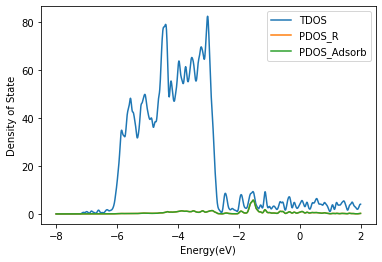

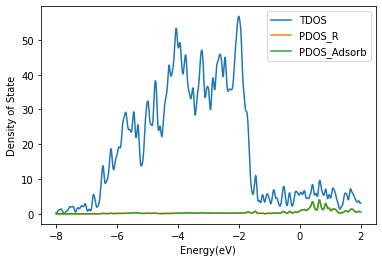

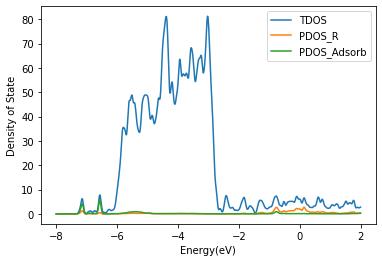

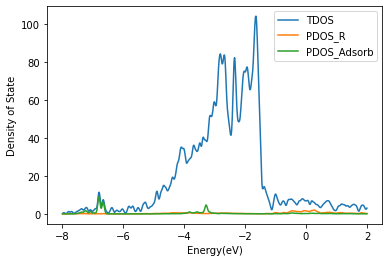

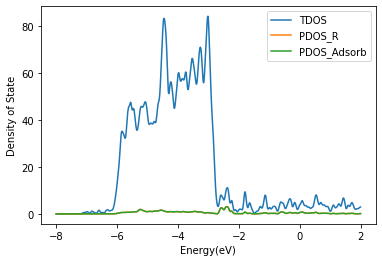

In [13]:
for j in range(5):
    i = np.random.randint(0, y.shape[0]-1)
    plt.plot(x_tdos[i][0][1], x_tdos[i][0][0], label="TDOS")
    plt.plot(x_pdos_r[i][0][1], x_pdos_r[i][0][0], label="PDOS_R")
    plt.plot(x_pdos_adsorb[i][0][1], x_pdos_adsorb[i][0][0], label="PDOS_Adsorb")
    plt.xlabel("Energy(eV)")
    plt.ylabel("Density of State")
    plt.legend()
    plt.show()

# DOS Model Construction

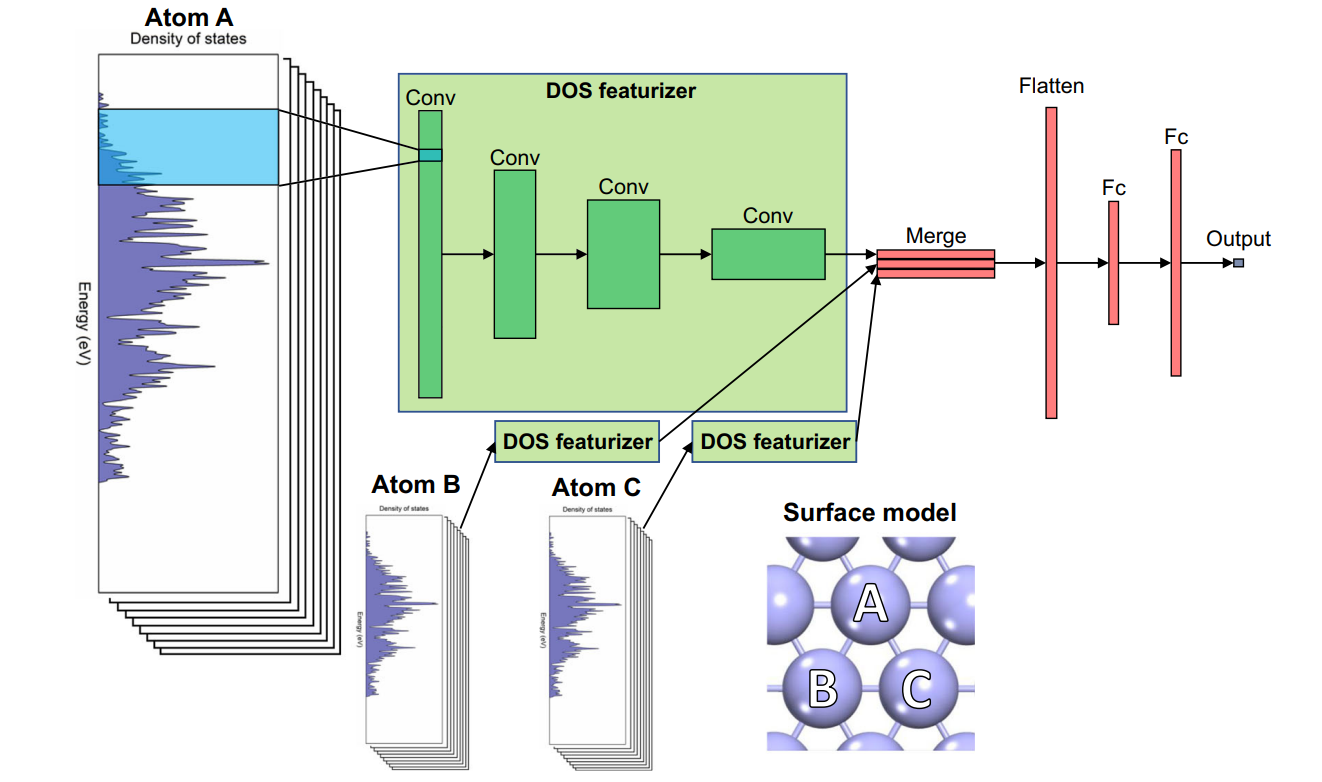

## Model Architecture
DOS Model with DeepConvNet

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.dropout_rate = 0.5
        
        self.dos_featurizer = nn.Sequential(
            
            nn.Conv2d(1, 25, kernel_size=(1, 5)),
            
            nn.Conv2d(25, 25, kernel_size=(2, 1)),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Conv2d(25, 50, kernel_size=(1, 5)),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Conv2d(50, 100, kernel_size=(1, 5)),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),

            nn.Conv2d(100, 200, kernel_size=(1, 5)),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(11600*3, 128),
            nn.ReLU(),
            nn.Linear(128, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
        
        
        
    def forward(self, tdos, pdos_r, pdos_adsorb):
        
        output1 = self.dos_featurizer(tdos)
        output2 = self.dos_featurizer(pdos_r)
        output3 = self.dos_featurizer(pdos_adsorb)
        
        output = torch.cat((output1, output2, output3), 1)
        
        output = self.fc(output)
        
        return output
    
model = ConvNet().to(device)
summary(model, [(1, 2, 1000), (1, 2, 1000), (1, 2, 1000)])

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 2, 996]             150
            Conv2d-2           [-1, 25, 1, 996]           1,275
       BatchNorm2d-3           [-1, 25, 1, 996]              50
              ReLU-4           [-1, 25, 1, 996]               0
         MaxPool2d-5           [-1, 25, 1, 498]               0
           Dropout-6           [-1, 25, 1, 498]               0
            Conv2d-7           [-1, 50, 1, 494]           6,300
       BatchNorm2d-8           [-1, 50, 1, 494]             100
              ReLU-9           [-1, 50, 1, 494]               0
        MaxPool2d-10           [-1, 50, 1, 247]               0
          Dropout-11           [-1, 50, 1, 247]               0
           Conv2d-12          [-1, 100, 1, 243]          25,100
      BatchNorm2d-13          [-1, 100, 1, 243]             200
             ReLU-14

## Data Loader

In [128]:
from sklearn.model_selection import train_test_split

x_tdos_train, x_tdos_val, x_pdos_r_train, x_pdos_r_val, x_pdos_adsorb_train, x_pdos_adsorb_val, \
    y_train, y_val = train_test_split(x_tdos, x_pdos_r, x_pdos_adsorb, y, test_size=0.2, random_state=8888)

x_tdos_train = torch.from_numpy(x_tdos_train).float().to(device)
x_pdos_r_train = torch.from_numpy(x_pdos_r_train).float().to(device)
x_pdos_adsorb_train = torch.from_numpy(x_pdos_adsorb_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
x_tdos_val = torch.from_numpy(x_tdos_val).float().to(device)
x_pdos_r_val = torch.from_numpy(x_pdos_r_val).float().to(device)
x_pdos_adsorb_val = torch.from_numpy(x_pdos_adsorb_val).float().to(device)
y_val = torch.from_numpy(y_val).float().to(device)

train = torch.utils.data.TensorDataset(x_tdos_train, x_pdos_r_train, x_pdos_adsorb_train, y_train)
val = torch.utils.data.TensorDataset(x_tdos_val, x_pdos_r_val, x_pdos_adsorb_val, y_val)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

## Training & Validation

In [129]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc, n_correct  = 0, 0, 0
    for batch, (x1, x2, x3 , y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x1, x2, x3)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record
        avg_loss += loss.item()
        n_correct += torch.sum((torch.abs(pred[:, 0] - y) < torch.abs(0.1* y))).item()
#         if batch % 10 == 0:
#             loss, current = loss.item(), batch * len(x)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_acc = (n_correct / size * 100.0)  # scalar
    avg_loss /=  size
#     print(f"Train Error: \n Accuracy: {(avg_acc):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    return avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x1, x2, x3, y in dataloader:
            pred = model(x1, x2, x3)
            test_loss += loss_fn(pred, y).item()
            correct += torch.sum((torch.abs(pred[:, 0] - y) < torch.abs(0.1* y))).item()

    correct = (correct / size * 100.0 ) # scalar  test_loss /= len(test_loader)
    test_loss /=  size
    
#     print(f"Test Error: \n Accuracy: {(correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [130]:
epochs = 1000
learning_rate = 1e-2
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_acc = []
train_loss = []
test_acc = []
test_loss = []
for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss)
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    
    if(t%10==0 or t==epochs-1):            
        print(f"Epoch {t+1}\n-------------------------------")
        print(f"Train Error: \n Accuracy: {(tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(te_acc):>0.1f}%, Avg loss: {te_loss:>8f} \n")


print("Done!")

# print("Saving model weight...")
# torch.save(model, "./DeepConvNet_model.pt")
# print("Save Done!")

/work/alanchen0922/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/work/alanchen0922/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/work/alanchen0922/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure 

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 1.3%, Avg loss: 3367.910680 

Test Error: 
 Accuracy: 2.6%, Avg loss: 3.266235 

Epoch 11
-------------------------------
Train Error: 
 Accuracy: 3.2%, Avg loss: 1.881816 

Test Error: 
 Accuracy: 7.1%, Avg loss: 2.010780 

Epoch 21
-------------------------------
Train Error: 
 Accuracy: 3.2%, Avg loss: 1.892462 

Test Error: 
 Accuracy: 4.5%, Avg loss: 1.915554 

Epoch 31
-------------------------------
Train Error: 
 Accuracy: 3.1%, Avg loss: 1.914588 

Test Error: 
 Accuracy: 8.4%, Avg loss: 2.199935 

Epoch 41
-------------------------------
Train Error: 
 Accuracy: 3.2%, Avg loss: 1.980023 

Test Error: 
 Accuracy: 8.4%, Avg loss: 2.100625 

Epoch 51
-------------------------------
Train Error: 
 Accuracy: 2.9%, Avg loss: 1.909849 

Test Error: 
 Accuracy: 7.8%, Avg loss: 2.023991 

Epoch 61
-------------------------------
Train Error: 
 Accuracy: 3.1%, Avg loss: 1.912548 

Test Error: 
 Accuracy: 7.1%, Avg loss: 1

Epoch 571
-------------------------------
Train Error: 
 Accuracy: 2.9%, Avg loss: 1.891690 

Test Error: 
 Accuracy: 7.1%, Avg loss: 1.835494 

Epoch 581
-------------------------------
Train Error: 
 Accuracy: 3.1%, Avg loss: 1.917731 

Test Error: 
 Accuracy: 8.4%, Avg loss: 2.450333 

Epoch 591
-------------------------------
Train Error: 
 Accuracy: 3.2%, Avg loss: 1.907711 

Test Error: 
 Accuracy: 8.4%, Avg loss: 2.345270 

Epoch 601
-------------------------------
Train Error: 
 Accuracy: 3.1%, Avg loss: 1.868703 

Test Error: 
 Accuracy: 7.8%, Avg loss: 2.215573 

Epoch 611
-------------------------------
Train Error: 
 Accuracy: 3.1%, Avg loss: 1.895017 

Test Error: 
 Accuracy: 8.4%, Avg loss: 1.874398 

Epoch 621
-------------------------------
Train Error: 
 Accuracy: 2.9%, Avg loss: 1.880702 

Test Error: 
 Accuracy: 8.4%, Avg loss: 1.987537 

Epoch 631
-------------------------------
Train Error: 
 Accuracy: 3.1%, Avg loss: 1.890521 

Test Error: 
 Accuracy: 7.8%, Avg lo

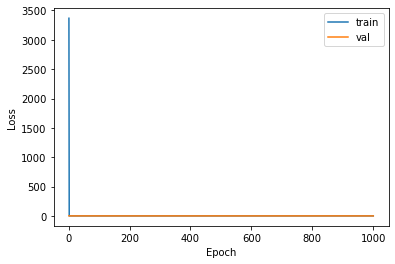

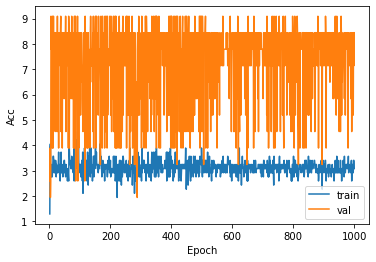

In [131]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
# plt.ylim(0, 0.01)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="train")
plt.plot(x, test_loss, label='val')
plt.legend()
plt.show()

plt.figure()
plt.ylabel("Acc")
plt.xlabel("Epoch")
# plt.ylim(0, 0.01)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_acc, label="train")
plt.plot(x, test_acc, label='val')
plt.legend()
plt.show()

## Correlation of Ground Truth and Prediction

In [132]:
test_loss, correct = 0, 0
with torch.no_grad():
    pred = model(x_tdos_val, x_pdos_r_val, x_pdos_adsorb_val)
    test_loss += loss_fn(pred, y_val).item()
#     correct = torch.sum((torch.abs(pred - y) < torch.abs(0.1* y)))
test_loss /=  len(x_tdos)
print("Loss:", test_loss)

Loss: 0.1358395663174716


/work/alanchen0922/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([154])) that is different to the input size (torch.Size([154, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Corr: nan
Loss: 0.1358


/work/alanchen0922/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


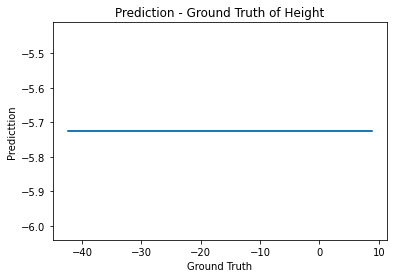

In [133]:
from scipy.stats import pearsonr

# print(y_val.cpu().shape)
# print(pred.cpu().numpy()[:,0])
plt.title( "Prediction - Ground Truth of Height")
plt.xlabel( "Ground Truth")
plt.ylabel( "Predicttion")
plt.plot( y_val.cpu().numpy(), pred.cpu().numpy()[:,0] )# plot( x, y)
corr, _ = pearsonr(y_val.cpu().numpy(), pred.cpu().numpy()[:,0])
slope = "Corr: " + "%.4f"%corr + "\nLoss: " + "%.4f"%test_loss
print(slope)
# plt.text( 0, , slope)
plt.show()